In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/ali/anaconda3/envs/tfkeras/lib/python3.6/site-packages')

import numpy as np
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..'))) # To import keras_squeezenet.
from keras_squeezenet import SqueezeNet
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image

Using TensorFlow backend.


In [2]:
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
img = image.load_img('../images/cat.jpeg', target_size=(227, 227))

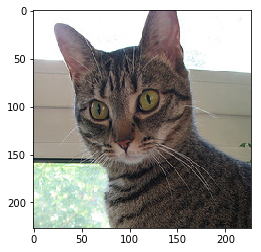

In [4]:
# Let's check out this nice lookin' cat!
plt.imshow(img)

In [5]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

<h1>Randomly initialized weights</h1>
<p>The weights should look random, and it should not be able to predict the correct class.</p>

In [6]:
# Get weights that are not trained (i.e., randomly initialized)
model = SqueezeNet(weights=None)

(3, 3, 3, 64)


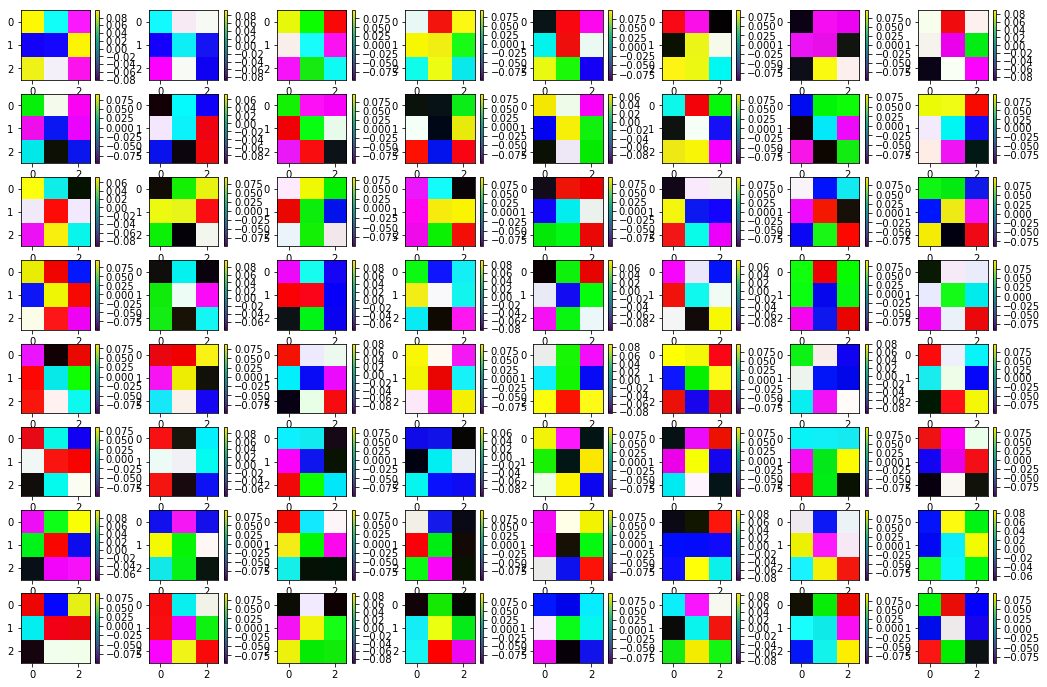

In [7]:
W = K.eval(model.weights[0])
print(W.shape)
plt.figure(figsize=(18,12))
for idx in range(W.shape[-1]):
    plt.subplot(8,8,idx+1)
    plt.imshow(W[:,:,:,idx]); plt.colorbar()

In [8]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds))
# These predictions should look random (since the network is not trained)!

Predicted: [[('n03372029', 'flute', 0.0010306132), ('n02965783', 'car_mirror', 0.001029918), ('n02088364', 'beagle', 0.0010297303), ('n02966687', "carpenter's_kit", 0.0010296991), ('n03884397', 'panpipe', 0.0010286622)]]


<h1>Weights pretrained over ImageNet</h1>
<p>Check to make sure we can get the pretrained weights. The weights should have some structure, and the classification should be pretty good, since the model is already trained.</p>

In [9]:
# Get weights that are trained over ImageNet.
model = SqueezeNet(weights='imagenet')

(3, 3, 3, 64)


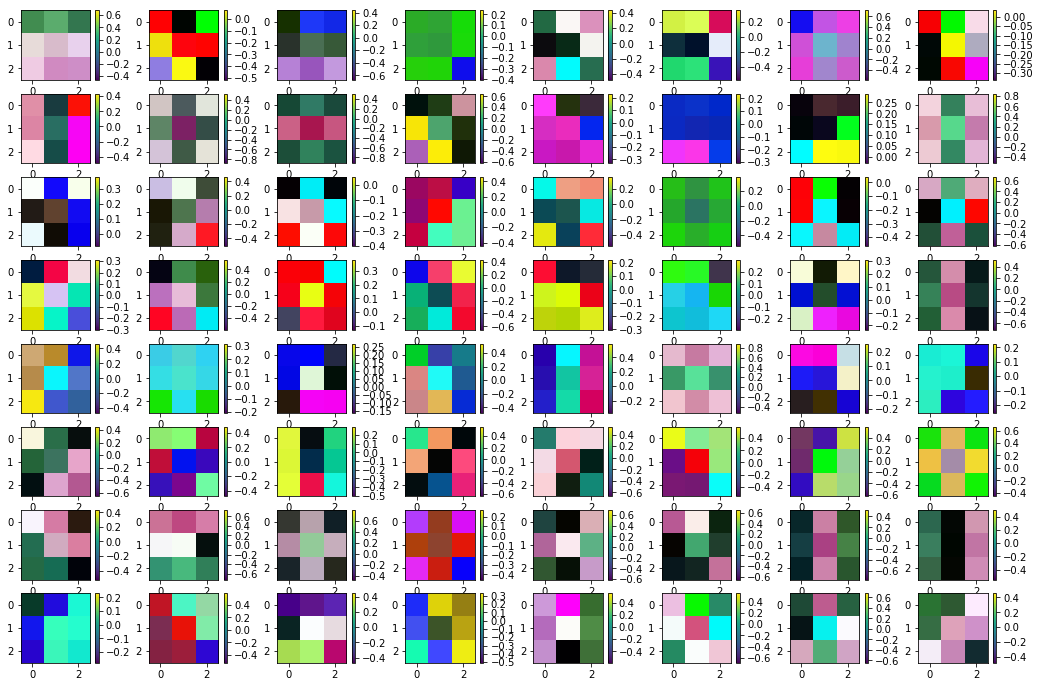

In [10]:
W = K.eval(model.weights[0])
print(W.shape)
plt.figure(figsize=(18,12))
for idx in range(W.shape[-1]):
    plt.subplot(8,8,idx+1)
    plt.imshow(W[:,:,:,idx]); plt.colorbar()

In [11]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds))
# Alright! These look good!

Predicted: [[('n02123045', 'tabby', 0.82134342), ('n02124075', 'Egyptian_cat', 0.12180641), ('n02123159', 'tiger_cat', 0.05682119), ('n02127052', 'lynx', 2.2597995e-05), ('n02129604', 'tiger', 5.1768461e-06)]]


<h1>Weights for no_top</h1>
<p>Here we will save the weights for when include_top is False. We'll do this by popping off the last few layers to get the layers we want.</p>

In [12]:
# This is the full model layers.
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 227, 227, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 113, 113, 64)  1792                                         
____________________________________________________________________________________________________
relu_conv1 (Activation)          (None, 113, 113, 64)  0                                            
____________________________________________________________________________________________________
pool1 (MaxPooling2D)             (None, 56, 56, 64)    0                                            
___________________________________________________________________________________________

In [13]:
#model.save_weights('../weights/squeezenet_weights_tf_dim_ordering_tf_kernels.h5')

In [14]:
# We don't want to use the last layer, so we'll pop() off the 1) loss, 2) pooling, 3) relu, 4) conv10, 5) dropout layers.
num_layers_to_pop = 5
for idx in range(num_layers_to_pop):
    print(model.layers.pop())

In [15]:
#model.layers.pop()

In [16]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 227, 227, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 113, 113, 64)  1792                                         
____________________________________________________________________________________________________
relu_conv1 (Activation)          (None, 113, 113, 64)  0                                            
____________________________________________________________________________________________________
pool1 (MaxPooling2D)             (None, 56, 56, 64)    0                                            
___________________________________________________________________________________________

In [17]:
#model.save_weights('../weights/squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5')
last= model.output
x=model.layers[-1].output
print(x.shape)

(?, 13, 13, 512)


In [18]:
from keras.layers import Dropout,Convolution2D,Activation,GlobalAveragePooling2D
from keras.models import Model
classes=2
last1 = model.layers[-1].output
x = Dropout(0.5, name='drop9')(last1)
x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
x = Activation('relu', name='relu_conv10')(x)
x = GlobalAveragePooling2D()(x)
x = Activation('softmax', name='loss')(x)
model = Model(model.input,x)

In [19]:
model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 227, 227, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 113, 113, 64)  1792                                         
____________________________________________________________________________________________________
relu_conv1 (Activation)          (None, 113, 113, 64)  0                                            
____________________________________________________________________________________________________
pool1 (MaxPooling2D)             (None, 56, 56, 64)    0                                            
___________________________________________________________________________________________

In [20]:
from keras.optimizers import SGD
sgd = SGD(lr=0.001, decay=0.0002, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# training
train_data_dir = '/home/ali/anaconda3/envs/tfkeras/courses/deeplearning1/nbs/data/dogscats/train'
validation_data_dir = '/home/ali/anaconda3/envs/tfkeras/courses/deeplearning1/nbs/data/dogscats/valid'
nb_train_samples = 2000
nb_validation_samples = 800
nb_epoch = 500

In [22]:
 #   Generator
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)

<h1>include_top Checks</h1>
<p>Check if include_top flag now works</p>

In [23]:
test_datagen = ImageDataGenerator(rescale=1./255)
width=227
height=227
train_generator = train_datagen.flow_from_directory(train_data_dir,target_size=(width, height),batch_size=16
                                    ,class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_data_dir,target_size=(width, height)
                                                            ,batch_size=16,class_mode='categorical')


Found 5201 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [24]:
from visual_callbacks import AccLossPlotter
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Instantiate AccLossPlotter to visualise training
plotter = AccLossPlotter(graphs=['acc', 'loss'], save_graph=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0)
checkpoint = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss',verbose=0,save_best_only=True,save_weights_only=True,mode='min',period=1) 

In [ ]:
model.fit_generator(train_generator,samples_per_epoch=nb_train_samples,nb_epoch=nb_epoch,
                 validation_data=validation_generator,nb_val_samples=nb_validation_samples, callbacks=[plotter, checkpoint])

/home/ali/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., callbacks=[<visual_c..., steps_per_epoch=125, epochs=500, validation_steps=800)`
  from ipykernel import kernelapp as app


Epoch 1/500
125/125 [==============================] - 47s - loss: 0.6965 - acc: 0.4885 - val_loss: 0.6931 - val_acc: 0.5002

In [ ]:
model.save_weights('weights.h5')

In [ ]:
from keras.utils import get_file

In [ ]:
model = SqueezeNet(include_top=False, weights='imagenet')

In [ ]:
out = model.predict(x)

In [ ]:
print(out.shape)

In [ ]:
plt.imshow(np.squeeze(out[0,:,:,102])); plt.colorbar()

In [ ]:
model = SqueezeNet(include_top=False, weights='imagenet', pooling='avg')

In [ ]:
out = model.predict(x)
print(out.shape)